In [1]:
import os
import sys
sys.path.append("/home/dux/")
sys.path.append("/home/dux/surface_sampling/sgmc_surf")
import pickle

import numpy as np

import ase
from ase.calculators.lammpsrun import LAMMPS
from ase.io import read

import catkit
from catkit.gen.adsorption import get_adsorption_sites

from mcmc import mcmc_run, get_adsorption_coords

# from htvs.djangochem.pgmols.utils import surfaces
from matplotlib import pyplot as plt

os.environ["LAMMPS_POTENTIALS"]="/home/dux/lammps/potentials/"
os.environ["LAMMPS_COMMAND"]="/home/dux/lammps/src/lmp_serial"
os.environ["ASE_LAMMPSRUN_COMMAND"]=os.environ["LAMMPS_COMMAND"]

In [2]:
from time import perf_counter

start = perf_counter()
num_runs = 100

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Au_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Au_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=False, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

# Au from standard cell
# DEPRECATED as of 2022 0702
# atoms = read('Au_mp-81_conventional_standard.cif')
# slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[2,2])
# slab.write('Au_110_2x2_pristine_slab.cif')
# # also save a pkl object
# with open('Au_110_2x2_pristine_slab.pkl', 'wb') as slab_pkl:
#     pickle.dump(slab, slab_pkl)

slab_pkl = open('Au_110_2x2_pristine_slab.pkl', 'rb')
slab = pickle.load(slab_pkl)
# slab = read('Au_110_2x2_pristine_slab.pkl')

coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)

element = 'Au'
metal = catkit.gratoms.Gratoms(element)

ads_coords = get_adsorption_coords(slab, metal, connectivity)

/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In [3]:
len(slab)

16

In [4]:
len(coords)

48

In [5]:
all_adsorbed = read("Au_110_2x2_all_adsorbed_slab.cif")
assert len(all_adsorbed) == len(slab) + len(ads_coords)

Manually removed some atoms

In [6]:
proper_adsorbed = read("Au_110_2x2_proper_adsorbed_slab.cif")
ads_positions = proper_adsorbed.get_positions()[len(slab):]

Plot some slabs

<AxesSubplot:title={'center':'proper adsorbed'}>

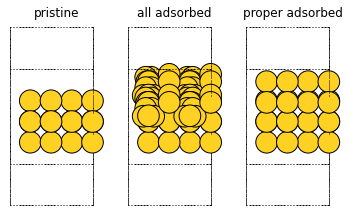

In [7]:
from ase.visualize.plot import plot_atoms

fig, ax = plt.subplots(1, 3)
labels = ['pristine', 'all adsorbed', 'proper adsorbed']
for i in range(3):
    ax[i].axis('off')
    ax[i].set_title(labels[i])
plot_atoms(slab, 
            ax[0], 
            radii=0.8, 
            rotation=("0x, 45y, 90z"))
plot_atoms(all_adsorbed, 
            ax[1], 
            radii=0.8, 
            rotation=("0x, 45y, 90z"))
plot_atoms(proper_adsorbed,
            ax[2], 
            radii=0.8, 
            rotation=("0x, 45y, 90z"))

In [8]:
ads_positions.shape

(8, 3)

In [9]:
len(ads_positions)

8

In [10]:
# slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
slab_pkl = open('Au_110_2x2_pristine_slab.pkl', 'rb')
slab = pickle.load(slab_pkl)

element = 'Au'
num_ads_atoms = 4 + 2 # for canonical runs
alpha = 0.9
num_sweeps = 50

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_sweeps=num_sweeps, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms, ads_coords=ads_positions)

INFO:Running with num_sweeps = 50, temp = 1, pot = 0, alpha = 0.9
INFO:there are 16 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f785a9ef430>
INFO:In pristine slab, there are a total of 8 sites
/home/dux/miniconda3/envs/surface_sampling/lib/python3.8/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 8 iterations per run over a total of 50 runs
INFO:adsorbate(s) is(are) Au
INFO:In sweep 1 out of 50
INFO:optim structure has Energy = -78.24488726806578
INFO:In sweep 2 out of 50
INFO:optim structure has Energy = -78.24488564746413
INFO:In sweep 3 out of 50
INFO:optim structure has Energy = -79.03491149100293
INFO:In sweep 4 out of 50
INFO:optim structure has Energy = -77.261455065257
INFO:In sweep 5 out of 50
INFO:optim structure has Energy = -77.26145742938893
INFO:In sweep 6 out of 50
INFO:optim structure has Energy = -78.24488564

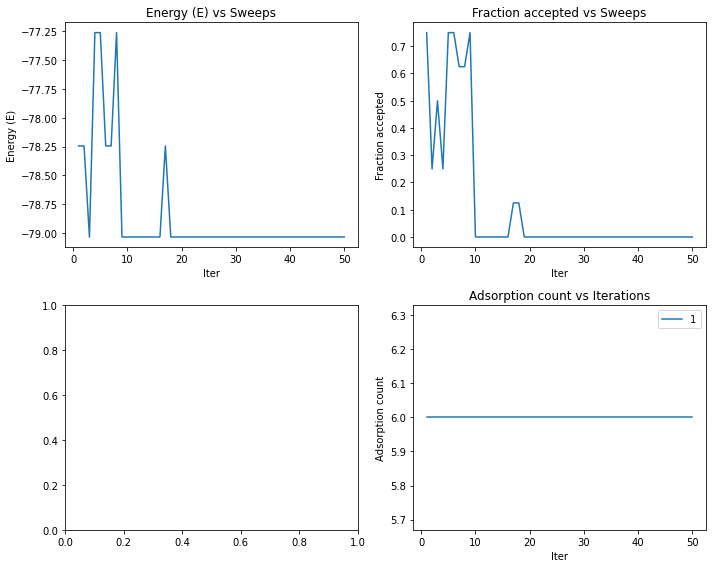

In [11]:
import matplotlib.pyplot as plt
runs = range(1, num_sweeps+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()